# Metatranscriptome data synthesis and plotting:
### Last updated S.Hu 03-07-2018

In [1]:
#Make sure these are all installed!
library(edgeR)
library(plyr)
library(dplyr)
library(reshape2)
library(ggplot2)
library(ggtern)
library(UpSetR)
library(vegan)

Loading required package: limma
Warning message:
“package ‘dplyr’ was built under R version 3.3.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggplot2’ was built under R version 3.3.2”Warning message:
“package ‘ggtern’ was built under R version 3.3.2”--
Consider donating at: http://ggtern.com
Even small amounts (say $10-50) are very much appreciated!
Remember to cite, run citation(package = 'ggtern') for further info.
--

Attaching package: ‘ggtern’

The following objects are masked from ‘package:ggplot2’:

    %+%, aes, annotate, calc_element, ggplot, ggplot_build,
    ggplot_gtable, ggplotGrob, ggsave, layer_data, theme, theme_bw,
    theme_classic, theme_dark, theme_gray,

# EdgeR normalization and importing annotation information

In [5]:
#from python script - OrthoMCL parsing
#rawdata<-read.csv("RawCounts_bycontig_annotated.csv", header=TRUE)
head(rawdata); names(rawdata)

X,K0_number,Level2,Depth,Cluster,Count,Sample10,Sample11,Sample12,Sample25,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31,Sample7,Sample8,Sample9
k99_1000000_deep890m,,Unannotated,deep890m,Cluster 83763,0,0,0,0,0,0,0,19,56,34,54,0,0,0
k99_1000000_surface,,Unannotated,surface,Cluster 2817082,0,1,2,0,0,0,0,0,0,0,0,0,0,0
k99_1000001_deep890m,,Uncertain,deep890m,Cluster 225311,0,0,0,0,4,0,7,3,7,12,7,0,0,0
k99_1000001_surface,,Unannotated,surface,Cluster 3149625,0,0,0,2,0,0,0,0,0,0,0,0,1,2
k99_1000005_deep150m,K01099,Ciliate,deep150m,Cluster 2358053,0,0,0,0,4,8,1,0,0,0,0,0,0,0
k99_1000005_deep890m,,Unannotated,deep890m,Cluster 30751,0,0,0,0,0,0,0,5,25,10,5,0,0,0


[1] "X"         "K0_number" "Level2"    "Depth"     "Cluster"   "Count"    
 [7] "Sample10"  "Sample11"  "Sample12"  "Sample25"  "Sample26"  "Sample27" 
[13] "Sample28"  "Sample29"  "Sample30"  "Sample31"  "Sample7"   "Sample8"  
[19] "Sample9"

In [ ]:
#To run through script with a small dataset use:
#rawdata<-read.csv("test_file_05022017.csv")

In [6]:
#Normalize among replicates
countfile<-rawdata[c(1:3,5,17:19,7:9,10:16)] #reorder columns so samples are in a row, Remove "Depth" and "Count" excess. 
dge.metaT<-DGEList(counts=countfile[,5:17],genes=countfile[1:4],group=c(rep("Surface",6),rep("Deep_150m",3),rep("Deep_890m",4)))
dge.metaT$samples
data<-calcNormFactors(dge.metaT,method = "TMM")
#plotMDS(data) #Option to plot in ordination space
cpm_data<-cpm(data, normalized.lib.sizes=TRUE, log=FALSE) #obtain only CPM (not logged)
cpm_data<-as.data.frame(cpm_data)  
data_CPM<-data.frame(data$genes,cpm_data)
#Calculate mean transcript CPM across replicates
data_CPM$MeanCPM_surface<-apply(data_CPM[5:10],1,FUN=mean)
data_CPM$MeanCPM_150m<-apply(data_CPM[11:13],1,FUN=mean)
data_CPM$MeanCPM_890m<-apply(data_CPM[14:17],1,FUN=mean)
#Output data_CPM has all data normalized between samples (depths).

,group,lib.size,norm.factors
Sample7,Surface,8035213,1
Sample8,Surface,4520002,1
Sample9,Surface,10514422,1
Sample10,Surface,13584570,1
Sample11,Surface,10822012,1
Sample12,Surface,9054206,1
Sample25,Deep_150m,18823004,1
Sample26,Deep_150m,11694061,1
Sample27,Deep_150m,21877382,1
Sample28,Deep_890m,6080055,1


## Generate Figure 2 bar plots
#### First import annotation information (in the form of R objects)

In [8]:
#Import taxonomic group names
key.wtax<-read.delim("TaxaName_bycontig.txt", header=TRUE, sep="\t")
head(key.wtax[1:2,])

contig_ID,K0_number,Level2,Taxa
k99_10000_surface,K13789,Haptophyte,Haptophyte
k99_1000000_surface,NA,NA from database,NA from database


In [9]:
names(data_CPM)

[1] "X"               "K0_number"       "Level2"          "Cluster"        
 [5] "Sample7"         "Sample8"         "Sample9"         "Sample10"       
 [9] "Sample11"        "Sample12"        "Sample25"        "Sample26"       
[13] "Sample27"        "Sample28"        "Sample29"        "Sample30"       
[17] "Sample31"        "MeanCPM_surface" "MeanCPM_150m"    "MeanCPM_890m"

In [13]:
#Bar plot to show mean relative abundance of taxonomic groups based on transcript abundances
contigTax<-data_CPM[c(1,18:20)] #isolate columns with mean CPM
colnames(contigTax)[1]<-"contig_ID"
contigTax2<-join(contigTax, key.wtax) #full taxa
MeanCPM_tax<-contigTax2[c(6:7,2:4)]

#Sum by mean transcript CPM
MeanCPM_tax_sum<-aggregate(MeanCPM_tax[3:5], by=list(Taxa=MeanCPM_tax$Taxa),sum)
m_tax_agg<-melt(MeanCPM_tax_sum)

#Factoring - set up for plot
variable<-c("MeanCPM_890m","MeanCPM_150m","MeanCPM_surface")
variable_labels<-c("890 m", "150 m", "Surface")
m_tax_agg$var<-factor(m_tax_agg$variable, levels=variable, labels = variable_labels)
tax_order=c("Dinoflagellate","Ciliate","Haptophyte","Diatom","Chlorophyte","Other eukaryote","Metazoa", "Multiple hits", "NA from database")
tax_color<-c("#c2a5cf","#d53e4f", "#f46d43", "#e6f598", "#5aae61", "#74add1", "#737373","#bdbdbd","#ffffff")
names(tax_color)<-tax_order
colScale<-scale_colour_manual(values=tax_color)
m_tax_agg$tax<-factor(m_tax_agg$Taxa, levels=rev(tax_order))


Joining by: contig_ID
Using Taxa as id variables


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


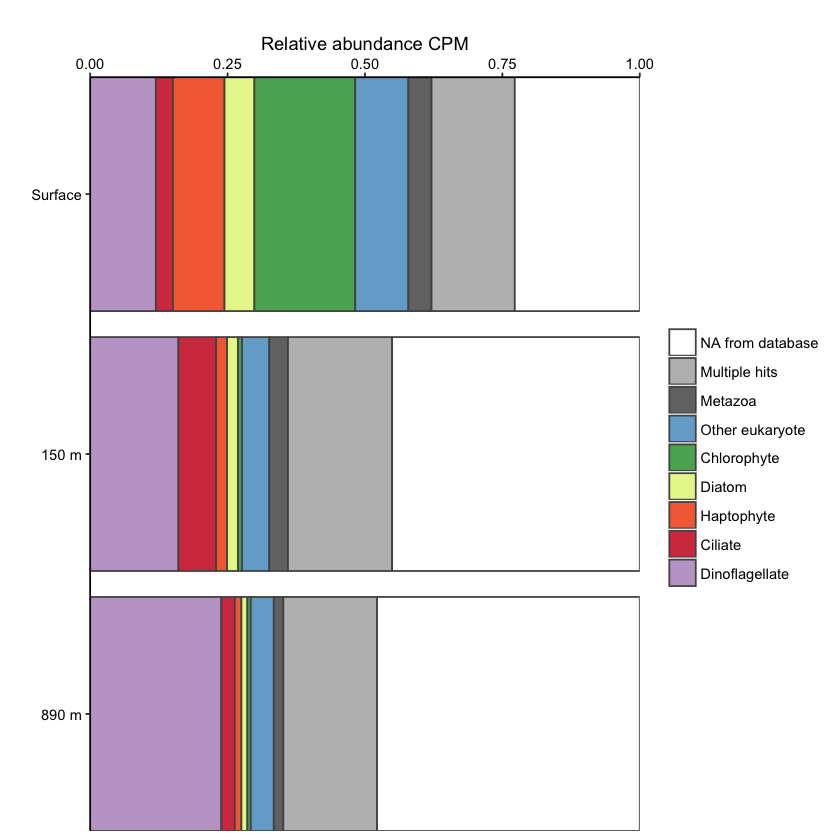

In [14]:
# Plot Figure 2
plot_tax<-ggplot(m_tax_agg[order(m_tax_agg$tax),],aes(y=value,x=var,fill=tax))+
    geom_bar(stat="identity", position="fill", color="#525252")+
    labs(title="", x="",y="Relative abundance CPM")+
    scale_x_discrete(labels=c("890 m","150m ","Surface"))+
    scale_x_discrete(limits=c(), expand = c(0, 0))+
    scale_fill_manual(values=tax_color)+
    coord_flip()+
    scale_y_continuous(position = "top", expand=c(0,0))+
    theme(legend.title=element_blank(),legend.position="right",legend.text.align=0, axis.text = element_text(color="black"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(),panel.border = element_blank(), axis.line = element_line())
plot_tax

In [ ]:
## Pie chart plots (for Figure 6)
#plot_tax_pie<-plot_tax+coord_polar(theta='y')+theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank(),axis.ticks.y=element_blank(),axis.text.y=element_blank(),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.border = element_blank(),panel.background = element_blank())
#plot_tax_pie
#plot_tax_pie %+% subset(m_tax_agg, var %in% "MeanCPM_surface") #W:400, H: 340
#plot_tax_pie %+% subset(m_tax_agg, var %in% "MeanCPM_150m")
#plot_tax_pie %+% subset(m_tax_agg, var %in% "MeanCPM_890m")
#d<-dcast(m_tax_agg[c(1:3)], Taxa~variable)
#write.csv(d, file="Perct_TaxbyDepth.csv")

## For supplementary Table about taxonomic composition
#suppTable<-aggregate(MeanCPM_tax[3:5], by=list(Taxa=MeanCPM_tax$Taxa, Taxa2=MeanCPM_tax$Level2),sum)
#write.csv(suppTable, file="Supple_TaxTable.csv")

### Note: for miTag analysis see: miTag_R.ipynb in this repo

## UpsetR plot, Figure 3

In [7]:
#library(UpSetR)

In [12]:
#Contig and ortholog distribution import (from Parse and compile python script)
tax_binary<-read.csv("Ortho_groups_by_taxa_binary.csv")
depth_binary<-read.csv("Ortho_by_depth_Binary.csv")

[1] 3935961

[1] "Annotated"   "Unannotated"

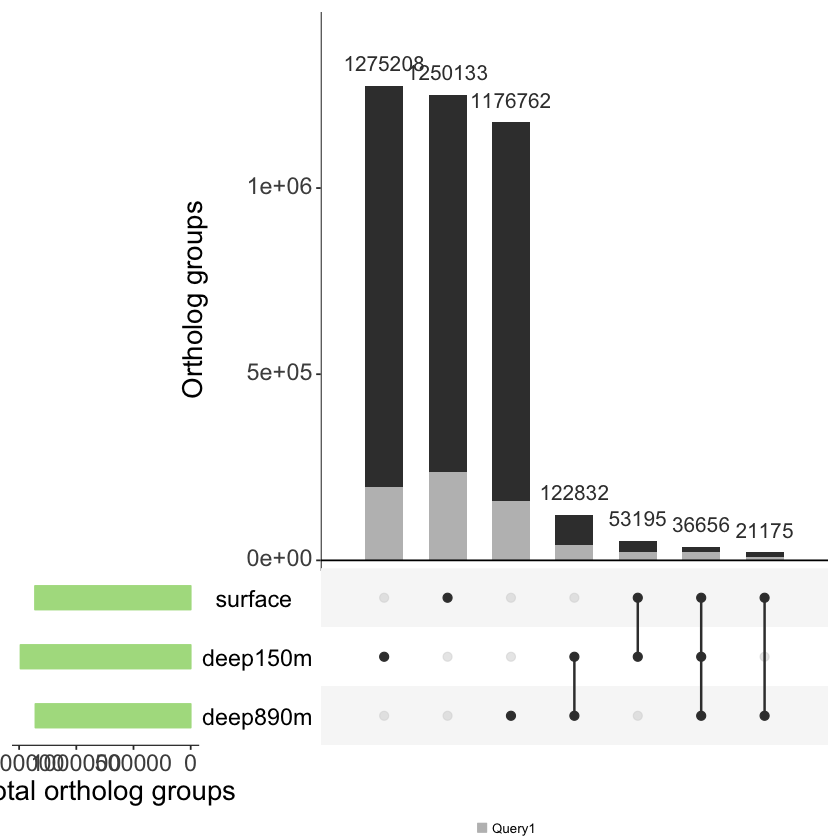

In [15]:
length(unique(depth_binary$Cluster))
annot<-read.delim("Annotated_withKO_ids.txt",header=F); colnames(annot)[1]<-"Cluster"; annot$annot<-"Annotated" #Import, change name, add a column
depth_bin_annt<-join(depth_binary, annot, by="Cluster",type="left")

#Relabel "NAs"
depth_bin_annt[is.na(depth_bin_annt)]<-"Unannotated"
unique(depth_bin_annt$annot)

#Plot Figure 3:
upset(depth_bin_annt,nsets=3,keep.order = TRUE,sets=c("deep890m", "deep150m", "surface"),order.by="freq",text.scale = 2,queries = list(list(query=intersects, params=list("annot","Annotated"),color="grey",active=TRUE)), mainbar.y.label = "Ortholog groups", sets.x.label = "Total ortholog groups", sets.bar.color = "#addd8e",query.legend = "bottom")

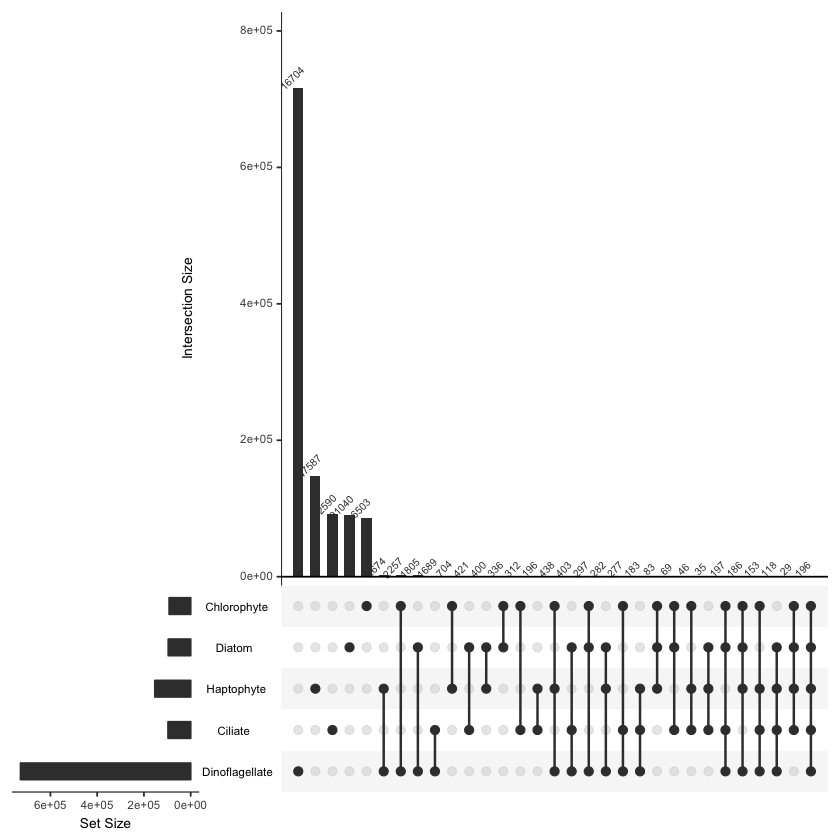

In [16]:
#Figure S4
upset(tax_binary,nsets=5,keep.order = TRUE,text.scale = 1, sets=c("Dinoflagellate", "Ciliate", "Haptophyte", "Diatom", "Chlorophyte"),number.angles = 45)

## Ternary plots
### whole community

In [17]:
#Take CPM data, sum by labeled CPM
#library(ggplot2)
#library(ggtern)

#start with data_CPM
#head(data_CPM)
#Import annotation information by contig
K0_label_path<-read.delim("AnnotationInfo_byPath.txt", header=T)

In [69]:
#Add Kegg and labeled info to CPM df
CPM_wAnnot<-join(data_CPM, K0_label_path)
#Rows will be repeated.
dim(data_CPM); dim(CPM_wAnnot) #CPM_wAnnot >> data_CPM wrt lines

Joining by: K0_number


[1] 5482399      20

[1] 5553590      22

In [71]:
#Format for plots:
CPM_wAnnot.m<-melt(CPM_wAnnot[c(1:2,21:22,18:20, 5:17)])
CPM_wAnnot.m.norm<-subset(CPM_wAnnot.m, !(value<0)) #Option to remove genes based on CPM value. 
CPM_wAnnot.m.norm.noNA<-CPM_wAnnot.m.norm[!is.na(CPM_wAnnot.m.norm$Label),] 
tmp<-CPM_wAnnot.m.norm.noNA[c(2:6)]
tri_input<-dcast(tmp, K0_number+Label+Gene_identification~variable,fun.aggregate = sum) #MAKE wide, and add where applicable
head(tri_input)
# Use "tri_input" dataframe from here below for statistical analyses

Using X, K0_number, Gene_identification, Label as id variables


K0_number,Label,Gene_identification,MeanCPM_surface,MeanCPM_150m,MeanCPM_890m,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,Sample25,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31
K01099,INPP5B_F; inositol polyphosphate 5-phosphatase INPP5B/F [EC:3.1.3.36],INPP5B_F; inositol polyphosphate 5-phosphatase INPP5B/F [EC:3.1.3.36],40.510159,50.084608,41.323303,49.972020,36.2458699,21.943618,50.371435,48.44568,36.082330,50.409637,29.068158,70.776029,7.2529376,57.168897,67.922300,32.949077
K13025,"EIF4A3, FAL1; ATP-dependent RNA helicase [EC:3.6.4.13]","EIF4A3, FAL1; ATP-dependent RNA helicase [EC:3.6.4.13]",89.454125,189.252657,182.104685,89.319147,68.5195897,92.436486,88.779654,89.20874,108.461128,198.289069,130.102779,239.366122,35.6093023,262.988497,274.519297,155.301645
K06841,SEMA5; semaphorin 5,SEMA5; semaphorin 5,70.117190,56.324814,38.689788,83.131024,67.6920584,47.022038,82.413265,75.56080,64.883952,55.685064,36.769977,76.519403,6.4664745,58.268298,61.318743,28.705635
K10408,"DNAH; dynein heavy chain, axonemal","DNAH; dynein heavy chain, axonemal",6147.700638,12222.260977,7261.679664,7277.467270,5931.7441898,4933.134284,7238.165330,7548.30701,3957.385744,13918.753813,8216.764818,14531.264301,1835.7796883,9476.207521,11855.443010,5879.288435
K07375,TUBB; tubulin beta,TUBB; tubulin beta,2281.588102,6895.604314,2723.860796,2287.737746,1765.7862377,1801.386154,2317.086011,2540.68671,2976.845752,7335.188284,4313.764262,9037.860395,745.3485744,3924.691044,4385.705192,1839.698374
K08114,PTPRZ; receptor-type tyrosine-protein phosphatase zeta [EC:3.1.3.48],PTPRZ; receptor-type tyrosine-protein phosphatase zeta [EC:3.1.3.48],1.707456,2.451937,2.518788,1.517842,0.4965188,1.446832,3.008294,2.16921,1.606038,3.098267,1.076598,3.180945,0.5243087,3.356069,2.658575,3.536201


In [73]:
#Targetted metabolic pathways and genes
paths<-c("Photosynthesis","Calvin cycle","Glycolysis","Gluconeogenesis","AMT","NRT","Nitrate reduction (assimilatory)","GS/GOGAT","PDH","por","Urea cycle","Fatty acid biosynthesis","Fatty acid breakdown","TCA cycle","Glyoxylate cycle","V-type ATPase","Lysosome associated","Chitinase")

In [74]:
#Generate ternary plot:
tri_mean<-tri_input[c(1:7)] # use means in ternary plot
tri_whole<-aggregate(tri_mean[5:7], by=list(Label=tri_mean$Label),sum)
tri_whole$sum<-apply(tri_whole[2:4],1,FUN=sum)
tri_whole<-subset(tri_whole, Label %in% paths) #only grab things that are in path!

In [75]:
#Factor and plot
tri_whole$pathway<-factor(tri_whole$Label, levels=paths)
path_color<-c("#b2df8a","#33a02c","#a6cee3","#1f78b4","#e31a1c","#fed976","#e7298a","#c7e9b4","#f03b20","#fd8d3c","#662506","#9e9ac8","#54278f","#01665e","#80cdc1","#ffffff","#878787","#000000")
names(path_color)<-paths
colScale<-scale_colour_manual(values=path_color)

In [77]:
#Plot:
plot_tri_whole<-ggtern(tri_whole,aes(MeanCPM_surface, MeanCPM_150m,MeanCPM_890m))+
    geom_point(shape=21,aes(size=sum,fill=pathway))+
    theme_rgbg()+
    scale_size(range = c(4,20))+
    theme_custom(base_size = 12, base_family = "",tern.plot.background = "transparent", tern.panel.background = "transparent",col.T = "#d95f0e", col.L = "#cb181d", col.R = "#2171b5",col.grid.minor = "white")+ 
    theme_showarrows()+
    theme_rotate(degrees = 240)+theme_clockwise()+
    theme(legend.title = element_text(size=16, face="bold"),legend.key=element_rect(fill='white'))+
    labs(title="",x="Surface",y="150m",z="890m",size="Relative CPM", label="Pathway")+
    scale_fill_manual(values=path_color)+ 
    theme_arrowlong()+theme_noticks()

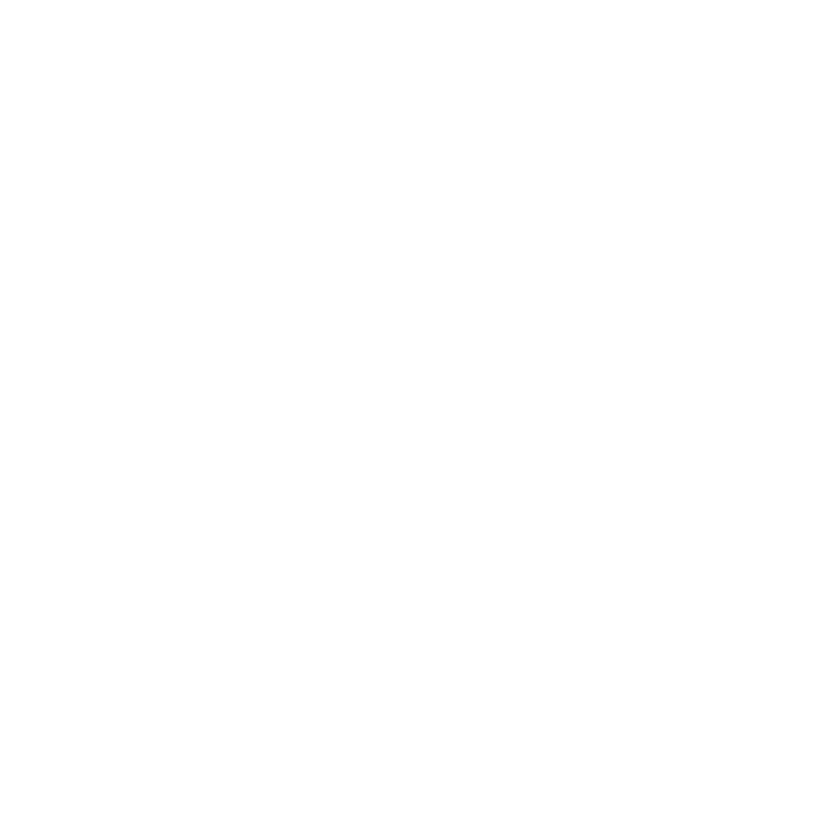

In [78]:
# Plot without labels
plot_tri_whole#+ guides(colour = guide_legend(override.aes = list(size=4.5)))

## In order to look at taxonomic group level, need to re-normalize for each individual taxonomic group:

In [26]:
# Start with raw data again
#rawdata<-read.csv("RawCounts_bycontig_annotated.csv", header=TRUE)
countfile<-rawdata[c(1:3,5,17:19,7:9,10:16)] #reorder columns so samples are in a row, Remove "Depth" and "Count" excess. 

In [27]:
# First add taxonomic names:
key.wtax<-read.delim("TaxaName_bycontig.txt", header=T)
head(key.wtax)

contig_ID,K0_number,Level2,Taxa
k99_10000_surface,K13789,Haptophyte,Haptophyte
k99_1000000_surface,NA,NA from database,NA from database
k99_1000002_surface,NA,NA from database,NA from database
k99_1000006_surface,NA,NA from database,NA from database
k99_1000007_surface,K13025,Chlorophyte,Chlorophyte
k99_1000008_surface,NA,Pelagophyceae,Other eukaryote


In [33]:
# Join read count information with taxonomic names
tmp<-countfile
colnames(tmp)[1]<-"contig_ID"
rawcounts_wtax<-join(tmp,key.wtax, by="contig_ID", type="left", match="first") #Contig names are unique, so it should be good to go
names(rawcounts_wtax)
dim(rawcounts_wtax); dim(tmp) #Should be the same

[1] "contig_ID" "K0_number" "Level2"    "Cluster"   "Sample7"   "Sample8"  
 [7] "Sample9"   "Sample10"  "Sample11"  "Sample12"  "Sample25"  "Sample26" 
[13] "Sample27"  "Sample28"  "Sample29"  "Sample30"  "Sample31"  "K0_number"
[19] "Level2"    "Taxa"

[1] 5482399      20

[1] 5482399      17

In [34]:
# Create subsets of data to look at specific taxonomic group differences.
# Subset only data I want to look at:
tax<-c("Dinoflagellate","Ciliate","Haptophyte","Diatom","Chlorophyte")
rawcounts_subtax<-subset(rawcounts_wtax, Taxa %in% tax) 

In [45]:
# Clean up dataframe
rawcounts_subtax<-rawcounts_subtax[c(1,20,2,4,5:17)]
head(rawcounts_subtax[1:2,])

,contig_ID,Taxa,K0_number,Cluster,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,Sample25,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31
5,k99_1000005_deep150m,Ciliate,K01099,Cluster 2358053,0,0,0,0,0,0,4,8,1,0,0,0,0
7,k99_1000005_surface,Dinoflagellate,,Cluster 3149516,1,1,1,1,2,0,0,0,2,0,0,0,0


In [46]:
# Generate dfs for each taxonomic group
for(i in unique(rawcounts_subtax$Taxa)) {
  nam <- paste("df", i, sep = "_")
  assign(nam, subset(rawcounts_subtax, Taxa %in% i))
}
# Output should be a bunch of "df_XXXX" where XXX is each taxa name..
# Save as R object:
# save(df_Dinoflagellate, df_Ciliate, df_Haptophyte, df_Diatom, df_Chlorophyte, file="eachTaxa_01272018.RData")
# load(file="eachTaxa_01272018.RData",verbose=T) # or pick up from here

### Series of 3 functions to run through each dataframe separately

In [47]:
#Input raw data by taxonomic group, Outputs DGE object that is normalized
norm_setup<-function(i){  
  dge.metaT<-DGEList(counts=i[,5:17],genes=i[1:4],group=c(rep("Surface",6),rep("Deep_150m",3),rep("Deep_890m",4)))
  # dge.metaT<-DGEList(counts=i[,3:15],genes=i[1:2],group=c(rep("Surface",6),rep("Deep_150m",3),rep("Deep_890m",4)))
  dge.metaT$samples
  data<-calcNormFactors(dge.metaT,method = "TMM")
  data$samples
  #trying to re-do stats
  design <- model.matrix(~0 + data$samples$group) #150m, 890m, surface
  rownames(design)<-colnames(data)
  # design
  # head(data$genes)
  return(data)
} 


# GLM_bytax, input is DGE object by tax created from "norm_setup", OUTPUT is raw data for supplementary tables.
GLM_bytax<-function(data){ #Perform GLM - probability distribution according to mean-variance relationship. edgeR defaults to using the Cox-Reid profile-adjusted likelihood method to estimate dispersions. Essentially fitting GLM with a design matrix.
  design <- model.matrix(~0 + data$samples$group) #150m, 890m, surface
  rownames(design)<-colnames(data)
  data <- estimateGLMCommonDisp(data, design) #Common dispersion for all tags
  data <- estimateGLMTrendedDisp(data, design, method="power") #Trended dispersion depending on tag abundance
  data<- estimateGLMTagwiseDisp(data,design) #separate disperions for individual tags
  data$common.dispersion
  #Now, dispersion estimates are calculated. So we need to test DE with quasi-likelihood F-test (QL F-test). Chosen because it provides more robust and reliable error rate control when the number of replicates is small
  fit<-glmQLFit(data,design) #First, fit negative binomial GLM for each tag
  # fit
  # design
  #
  # ?glmQLFit()
  qlf.890v150<-glmQLFTest(fit,contrast=c(-1,1,0)) # X v. Y = +X -Y
  df.890v150<-topTags( qlf.890v150 , n = nrow( qlf.890v150$table ) , sort.by = "logFC" )$table ; df.890v150$Design<- "u890d150"
  #
  qlf.surfv890<-glmQLFTest(fit,contrast=c(0,-1,1))
  df.surfv890<-topTags( qlf.surfv890 , n = nrow( qlf.surfv890$table ) , sort.by = "logFC" )$table ; df.surfv890$Design<- "uSurfd890"
    #
  qlf.surfv150<-glmQLFTest(fit,contrast=c(-1,0,1))
  df.surfv150<-topTags( qlf.surfv150 , n = nrow( qlf.surfv150$table ) , sort.by = "logFC" )$table ; df.surfv150$Design<- "uSurfd150"
  #
  allstats<-rbind(df.890v150, df.surfv150, df.surfv890)
  # head(K0_label_path)
  all_wGeneIDs<-join(allstats, K0_label_path, by="K0_number", type="left", match="all") #Duplicates where appropriate
  dim(all_wGeneIDs)
  head(all_wGeneIDs)
  paths<-c("Photosynthesis","Calvin cycle","Glycolysis","Gluconeogenesis","AMT","NRT","Nitrate reduction (assimilatory)","GS/GOGAT","PDH","por","Urea cycle","Fatty acid biosynthesis","Fatty acid breakdown","TCA cycle","Glyoxylate cycle","V-type ATPase","Lysosome associated","Chitinase")
  path_only<-subset(all_wGeneIDs, Label %in% paths)
  # write.csv(path_only, file="tmp.csv")
  #
  return(path_only)
}

# Input DGE object by tax (Created from "norm_setup"), Output: CPM table with means calculated - use this for plot visualization!
data_viz<-function(data){
  cpm_data<-cpm(data, normalized.lib.sizes=TRUE, log=FALSE) #obtain only CPM (not logged)
  cpm_data<-as.data.frame(cpm_data)
  data_CPM<-data.frame(data$genes,cpm_data)
  names(data_CPM)
  data_CPM$MeanCPM_surface<-apply(data_CPM[5:10],1,FUN=mean)
  data_CPM$MeanCPM_150m<-apply(data_CPM[11:13],1,FUN=mean)
  data_CPM$MeanCPM_890m<-apply(data_CPM[14:17],1,FUN=mean)
  # data_CPM$MeanCPM_surface<-apply(data_CPM[3:8],1,FUN=mean)
  # data_CPM$MeanCPM_150m<-apply(data_CPM[9:11],1,FUN=mean)
  # data_CPM$MeanCPM_890m<-apply(data_CPM[12:15],1,FUN=mean)
  return(data_CPM)
}

In [48]:
# First, normalize each data frame
DGEobj_Dinoflagellate <-norm_setup(df_Dinoflagellate)
DGEobj_Ciliate <-norm_setup(df_Ciliate)
DGEobj_Haptophyte <-norm_setup(df_Haptophyte)
DGEobj_Diatom <-norm_setup(df_Diatom)
DGEobj_Chlorophyte<-norm_setup(df_Chlorophyte)
#DGEobj_Chlorophyte$samples # check output
#DGEobj_Chlorophyte$genes # check output
#save(DGEobj_Dinoflagellate, DGEobj_Ciliate, DGEobj_Haptophyte, DGEobj_Diatom, DGEobj_Chlorophyte, file="DGEobjs_bytax.RData")

In [49]:
# Import annotation information
K0_label_path<-read.delim("AnnotationInfo_byPath.txt", header=T)
head(K0_label_path[1:2,])

# Run GLM calculation and annotate output
suppGLM_Dinoflagellate <-GLM_bytax(DGEobj_Dinoflagellate)
suppGLM_Ciliate <-GLM_bytax(DGEobj_Ciliate)
suppGLM_Haptophyte <-GLM_bytax(DGEobj_Haptophyte)
suppGLM_Diatom <-GLM_bytax(DGEobj_Diatom)
suppGLM_Chlorophyte<-GLM_bytax(DGEobj_Chlorophyte)
#
#save(suppGLM_Dinoflagellate, suppGLM_Ciliate, suppGLM_Haptophyte, suppGLM_Diatom, suppGLM_Chlorophyte, file="GLM_outputs_forsupplementary.RData")

K0_number,Gene_identification,Label
K09377,CSRP; cysteine and glycine-rich protein,CSRP; cysteine and glycine-rich protein
K03283,HSPA1_8; heat shock 70kDa protein 1/8,HSPA1_8; heat shock 70kDa protein 1/8


In [50]:
# Prep for plotting:
CPMnorm_Dinoflagellate <-data_viz(DGEobj_Dinoflagellate)
CPMnorm_Ciliate <-data_viz(DGEobj_Ciliate)
CPMnorm_Haptophyte <-data_viz(DGEobj_Haptophyte)
CPMnorm_Diatom <-data_viz(DGEobj_Diatom)
CPMnorm_Chlorophyte<-data_viz(DGEobj_Chlorophyte)
#
#save(CPMnorm_Dinoflagellate, CPMnorm_Ciliate, CPMnorm_Haptophyte, CPMnorm_Diatom, CPMnorm_Chlorophyte,file="Normed_bytax_dataviz.RData")

### Ternary plots for each taxonomic group

In [51]:
#Upload Robjects saved from before:
#load("Normed_bytax_dataviz.RData", verbose=T)
# set up environment
paths<-c("Photosynthesis","Calvin cycle","Glycolysis","Gluconeogenesis","AMT","NRT","Nitrate reduction (assimilatory)","GS/GOGAT","PDH","por","Urea cycle","Fatty acid biosynthesis","Fatty acid breakdown","TCA cycle","Glyoxylate cycle","V-type ATPase","Lysosome associated","Chitinase")
K0_label_path<-read.delim("AnnotationInfo_byPath.txt", header=T) #function import

In [52]:
# Format each dataframe for plotting
# fxn below joins with pathway information, allows duplication for visualization (duplication was not considered during normalization steps)
## Then aggregates by each pathway and generated a column of "summed CPM" for ternary plot datapoint size
format_triplot<-function(df){
  df_wpaths<-join(df, K0_label_path, by="K0_number", type="left", match="all") #Duplicates where appropriate
  #Then sum by what matters
  tri_input<-aggregate(df_wpaths[5:20], by=list(K0_number=df_wpaths$K0_number, Label=df_wpaths$Label, Taxa=df_wpaths$Taxa, Gene_identification=df_wpaths$Gene_identification),sum)
  tri_input$sum<-apply(tri_input[18:20],1,FUN=sum)
  tri_mean_sub<-subset(tri_input, Label %in% paths)
  return(tri_input)
}
#
tri_Dinoflagellate<-format_triplot(CPMnorm_Dinoflagellate)
tri_Ciliate<-format_triplot(CPMnorm_Ciliate)
tri_Haptophyte<-format_triplot(CPMnorm_Haptophyte)
tri_Diatom<-format_triplot(CPMnorm_Diatom)
tri_Chlorophyte<-format_triplot(CPMnorm_Chlorophyte)

In [53]:
# Ternary plot for each taxonomic group will appear as panels, so dataframes are combined here and saved
all_tmp<-rbind(tri_Dinoflagellate, tri_Ciliate, tri_Haptophyte, tri_Diatom, tri_Chlorophyte)
all_tri<-subset(all_tmp, Label %in% paths)
# save(all_tri,paths,tri_Dinoflagellate, tri_Ciliate, tri_Haptophyte, tri_Diatom, tri_Chlorophyte, file="TriInputs_byTaxa.RData")
# load(file="TriInputs_byTaxa.RData",verbose=T)

In [54]:
# Format for plotting:
tri_input<-aggregate(all_tri[5:21], by=list(Label=all_tri$Label, Taxa=all_tri$Taxa),sum)
#
tri_input$pathway<-factor(tri_input$Label, levels=paths)
path_color<-c("#b2df8a","#33a02c","#a6cee3","#1f78b4","#e31a1c","#fed976","#e7298a","#c7e9b4","#f03b20","#fd8d3c","#662506","#9e9ac8","#54278f","#01665e","#80cdc1","#ffffff","#878787","#000000")
names(path_color)<-paths
colScale<-scale_colour_manual(values=path_color)
#path_color<-c("#b2df8a","#33a02c","#a6cee3","#1f78b4","#fed976","#fed976","#fa9fb5","#fa9fb5","#fd8d3c","#fd8d3c","#e31a1c","#9e9ac8","#54278f","#80cdc1","#80cdc1","#ffffff","#878787","#000000")
#fillScale<-scale_fill_manual(values=path_color)
#names(path_color)<-paths
unique(tri_input$Label)
tax_order<-c("Dinoflagellate", "Ciliate","Haptophyte", "Diatom", "Chlorophyte")
tax_label<-c("A. Dinoflagellate", "B. Ciliate","C. Haptophyte", "D. Diatom", "E. Chlorophyte")
tri_input$Taxa_order<-factor(tri_input$Taxa, levels=tax_order, labels = tax_label)
#library(ggtern)

[1] AMT                              Calvin cycle                    
 [3] Chitinase                        Fatty acid biosynthesis         
 [5] Fatty acid breakdown             Gluconeogenesis                 
 [7] Glycolysis                       Glyoxylate cycle                
 [9] GS/GOGAT                         Lysosome associated             
[11] Nitrate reduction (assimilatory) NRT                             
[13] PDH                              Photosynthesis                  
[15] por                              TCA cycle                       
[17] Urea cycle                       V-type ATPase                   
10119 Levels:  ... ZYX; zyxin

In [55]:
# Ternary base plot:
plot_tri_gene_tax<-ggtern(tri_input[order(tri_input$Taxa_order),],aes(MeanCPM_surface, MeanCPM_150m,MeanCPM_890m))+
    geom_point(shape=21,aes(size=sum,fill=pathway), color="black",alpha=0.9)+theme_rgbg()+
    scale_size(range = c(4,18))+
    theme_custom(base_size = 9, base_family = "",tern.plot.background = "transparent", tern.panel.background = "transparent",col.T = "#d95f0e", col.L = "#cb181d", col.R = "#2171b5",col.grid.minor = "white")+ 
    theme_showarrows()+
    theme_rotate(degrees = 240)+
    theme_clockwise()+
    theme(legend.title = element_text(size=12, face="bold"),legend.key=element_rect(fill='white'))+labs(title="",x="Surface",y="150m",z="890m")+
    labs(size="Total CPM", label="Pathway")+
    scale_fill_manual(values=path_color)+
    theme_arrowlong()+
    theme_noticks()

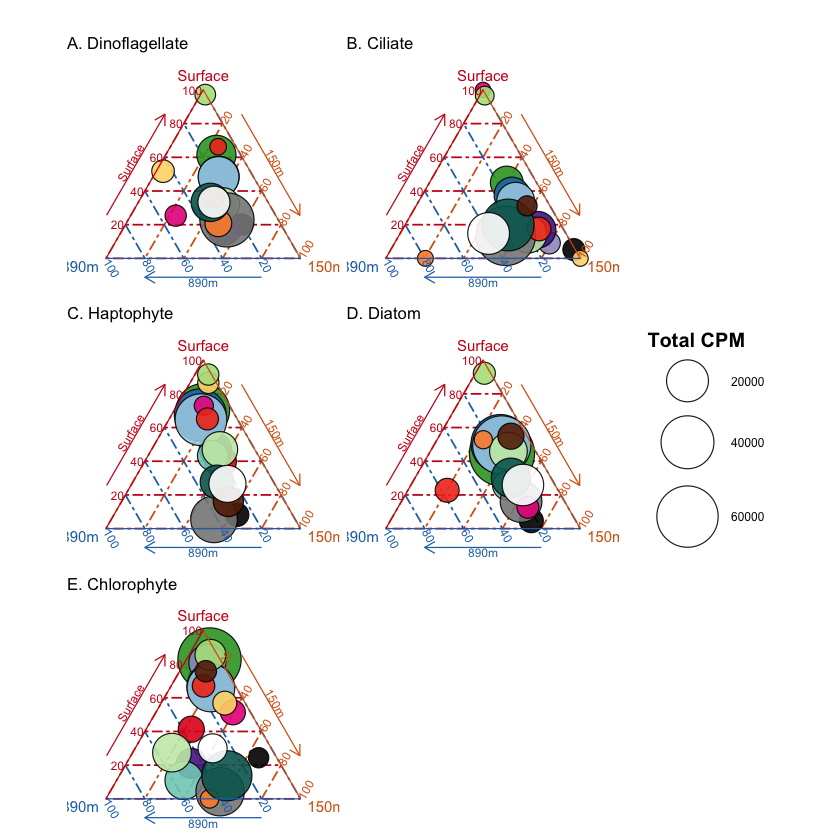

In [56]:
# Plot
plot_tri_gene_tax %+% subset(tri_input, Taxa %in% tax_order) + 
    facet_wrap(~Taxa_order, ncol=2) +
    theme(strip.text.x = element_text(angle=0, size=10,hjust=0, color="black"), axis.text.x=element_text(size=10,color="black"),strip.background = element_blank())+ 
    guides(colour = guide_legend(override.aes = list(size=4.5)))+
    guides(fill=FALSE)+
    annotate(geom="text")

# Generate CCA plot:

In [57]:
#CCA plot: Input COMMON K0s across taxonomic groups. Input .csv file created in python notebook
countfile_commonKO<-read.csv("Raw_Counts_ByTaxa_CommonKO.csv") #raw count file
dim(countfile_commonKO) #>8,000 contigs compiled, where accepted contigs for analysis had to have at least 1 count for K0 ID and taxonomic group
#length(unique(countfile_commonKO$K0_number)) #n=1603
#names(countfile_commonKO)
countfile<-countfile_commonKO[c(1:2,13:15,3:5,6:12)]

[1] 8011   15

In [59]:
#Normalize again, similar to above
#library(edgeR)
dge.metaT.cca<-DGEList(counts=countfile[,3:15],genes=countfile[1:2],group=c(rep("Surface",6),rep("Deep_150m",3),rep("Deep_890m",4)))
dge.metaT.cca$samples
data<-calcNormFactors(dge.metaT.cca,method="TMM") #normalize library using trimmed mean of M-values
cpm_data<-cpm(data, normalized.lib.sizes=TRUE, log=FALSE)
cpm_data<-as.data.frame(cpm_data)  
cca_cpm<-data.frame(data$genes,cpm_data)

,group,lib.size,norm.factors
Sample7,Surface,1274350,1
Sample8,Surface,710069,1
Sample9,Surface,1860397,1
Sample10,Surface,2211195,1
Sample11,Surface,1813604,1
Sample12,Surface,1606001,1
Sample25,Deep_150m,1715737,1
Sample26,Deep_150m,1067311,1
Sample27,Deep_150m,2059127,1
Sample28,Deep_890m,532798,1


In [60]:
#Calculate relative abundance the mean CPM by taxonomic group.
m.data_CPM<-melt(cca_cpm)
# group_by Taxa and variabe
norm.m.data_CPM<-m.data_CPM %>% group_by(Level2,variable) %>% mutate(count_norm=value/sum(value))
norm.m.data_CPM<-as.data.frame(norm.m.data_CPM)

#Make KEGG IDs column names:
cpm_PCA.w<-dcast(norm.m.data_CPM[c(1:3,5)],Level2+variable~K0_number,fill=0) #not logged, normalized counts by taxonomic group
#head(cpm_PCA.w[1:5])
#unique(cpm_PCA.w$variable)
row.names(cpm_PCA.w)<-paste(cpm_PCA.w$Level2,cpm_PCA.w$variable,sep="_")

Using K0_number, Level2 as id variables
Warning message:
“package ‘bindrcpp’ was built under R version 3.3.2”Using count_norm as value column: use value.var to override.


In [61]:
#format a key:
key_forPCA<-function(df){
  df$shape<-22 #surface
  deep150<-c("Sample25", "Sample26", "Sample27")
  df$shape[df$variable %in% deep150]=21
  deep890<-c("Sample28", "Sample29", "Sample30", "Sample31")
  df$shape[df$variable %in% deep890]=24
  #select taxa:
  df$taxcolor[df$Level2=="Dinoflagellate"]="#c2a5cf"
  df$taxcolor[df$Level2=="Ciliate"]="#d53e4f"
  df$taxcolor[df$Level2=="Diatom"]="#e6f598"
  df$taxcolor[df$Level2=="Chlorophyte"]="#5aae61"
  df$taxcolor[df$Level2=="Haptophyte"]="#f46d43"
  return(df)
}
cpm_PCA.w.key<-key_forPCA(cpm_PCA.w)

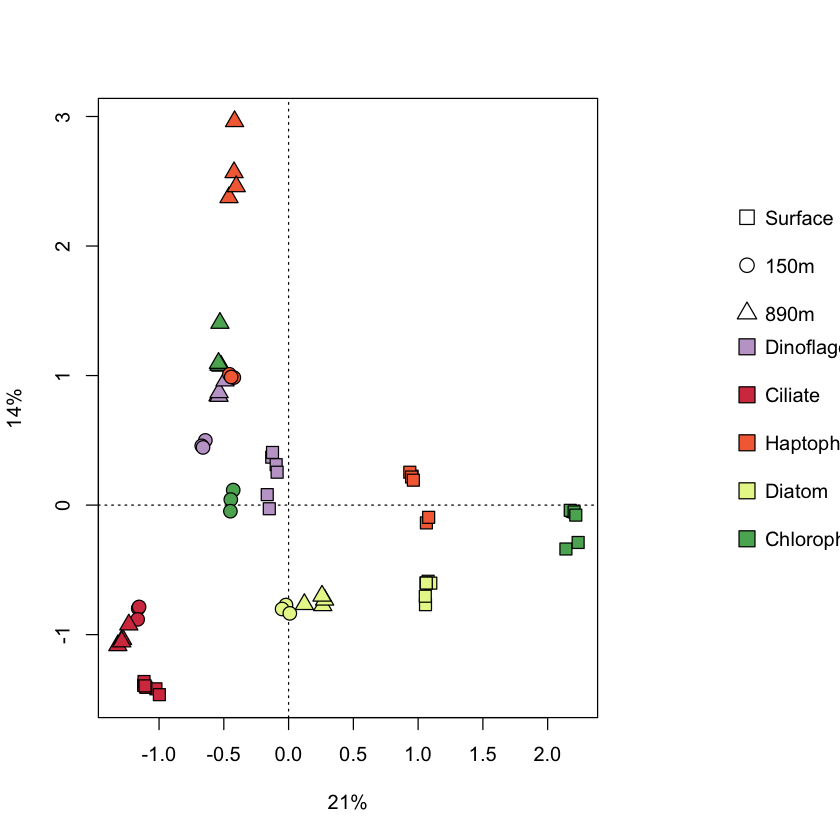

In [62]:
#Calculate CCA and plot
CCA_data<-cpm_PCA.w.key[3:1605] #only CCA input information
key<-cpm_PCA.w.key[c(1:2,1606:1607)] #get key for coloring and such
#^note on above lines, if calculating with own data, CCA input only takes numerics

ca<-cca(CCA_data,scaling=TRUE)

#CCA ploting set up:
par(xpd=FALSE,oma=c(0,0,0,8)) 
eig<-eigenvals(ca); x<-signif((eig[1]*100),3); y<-signif((eig[2]*100),3) #extract variances for CCA1 and CCA2 axes
plot(ca,type=c("points"),display=c("wa", "sites"),main="",xlab=bquote(.(x)*"%"), ylab=(bquote(.(y)*"%")))
points(ca,pch=key$shape,col="black",bg=key$taxcolor,cex=1.5)
par(xpd=NA) 
legend(3.4,2.5,c("Surface", "150m", "890m"),pch=c(0,1,2),col=c("black"),cex=1,pt.cex=1.6,bty="n",y.intersp=2)
legend(3.4,1.5,c("Dinoflagellate","Ciliate","Haptophyte","Diatom","Chlorophyte"),pch=22,pt.bg=c("#c2a5cf","#d53e4f", "#f46d43", "#e6f598", "#5aae61"),col=c("black","black","black","black","black"),y.intersp=2,bty="n",pt.cex=2,cex=1) 

# Statistical analysis for ternary plots
## Whole community

In [79]:
head(tri_input) #from above

K0_number,Label,Gene_identification,MeanCPM_surface,MeanCPM_150m,MeanCPM_890m,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,Sample25,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31
K01099,INPP5B_F; inositol polyphosphate 5-phosphatase INPP5B/F [EC:3.1.3.36],INPP5B_F; inositol polyphosphate 5-phosphatase INPP5B/F [EC:3.1.3.36],40.510159,50.084608,41.323303,49.972020,36.2458699,21.943618,50.371435,48.44568,36.082330,50.409637,29.068158,70.776029,7.2529376,57.168897,67.922300,32.949077
K13025,"EIF4A3, FAL1; ATP-dependent RNA helicase [EC:3.6.4.13]","EIF4A3, FAL1; ATP-dependent RNA helicase [EC:3.6.4.13]",89.454125,189.252657,182.104685,89.319147,68.5195897,92.436486,88.779654,89.20874,108.461128,198.289069,130.102779,239.366122,35.6093023,262.988497,274.519297,155.301645
K06841,SEMA5; semaphorin 5,SEMA5; semaphorin 5,70.117190,56.324814,38.689788,83.131024,67.6920584,47.022038,82.413265,75.56080,64.883952,55.685064,36.769977,76.519403,6.4664745,58.268298,61.318743,28.705635
K10408,"DNAH; dynein heavy chain, axonemal","DNAH; dynein heavy chain, axonemal",6147.700638,12222.260977,7261.679664,7277.467270,5931.7441898,4933.134284,7238.165330,7548.30701,3957.385744,13918.753813,8216.764818,14531.264301,1835.7796883,9476.207521,11855.443010,5879.288435
K07375,TUBB; tubulin beta,TUBB; tubulin beta,2281.588102,6895.604314,2723.860796,2287.737746,1765.7862377,1801.386154,2317.086011,2540.68671,2976.845752,7335.188284,4313.764262,9037.860395,745.3485744,3924.691044,4385.705192,1839.698374
K08114,PTPRZ; receptor-type tyrosine-protein phosphatase zeta [EC:3.1.3.48],PTPRZ; receptor-type tyrosine-protein phosphatase zeta [EC:3.1.3.48],1.707456,2.451937,2.518788,1.517842,0.4965188,1.446832,3.008294,2.16921,1.606038,3.098267,1.076598,3.180945,0.5243087,3.356069,2.658575,3.536201


In [81]:
#ANOVA stats on Whole community work:
#names(tri_input)
surface<-as.character(names(tri_input[7:12]))
d150<-as.character(names(tri_input[13:15]))
d890<-as.character(names(tri_input[16:19]))
#take replicates into account to perform ANOVA
aov_in<-melt(tri_input[c(1:3,7:19)])
aov_in$Depth[aov_in$variable %in% surface]="Surface"
aov_in$Depth[aov_in$variable %in% d150]="Deep150m"
aov_in$Depth[aov_in$variable %in% d890]="Deep890m"

#Pre-process:
#names(aov_in)
df_whole<-melt(aov_in[2:6]) #select Label, Gene IDs, and values and melt
#head(df_whole)
#AOV stats:
df<-subset(df_whole, Label %in% paths) #subset only pathways and genes of interest
datav <- data.frame(diff = double(),
                    lwr = double(),
                    upr = double(),
                    'p adj' = double(),
                    'Label' = character())

for (fxn in unique(df$Label)){
  depth <- aov(df$value[df$Label==fxn] ~ df$Depth[df$Label==fxn]) #run analysis of variance model
  hsd <- TukeyHSD(depth) #post-hoc statistics
  tmp <- as.data.frame(hsd$`df$Depth[df$Label == fxn]`) 
  tmp$Label <- fxn 
  datav <- rbind(datav, tmp)
}
head(datav)
#write.csv(datav, file="AOV_result_wholecomm.csv")

Using K0_number, Label, Gene_identification as id variables
Using Label, Gene_identification, variable, Depth as id variables


,diff,lwr,upr,p adj,Label
Deep890m-Deep150m,-294.88898,-528.873769,-60.90418,9.086258e-03,Lysosome associated
Surface-Deep150m,-483.15592,-699.783744,-266.52810,9.179123e-07,Lysosome associated
Surface-Deep890m,-188.26694,-386.020187,9.48630,6.583200e-02,Lysosome associated
Deep890m-Deep150m1,-17.07460,-70.483413,36.33421,7.327596e-01,Fatty acid biosynthesis
Surface-Deep150m1,55.40958,5.962628,104.85653,2.360236e-02,Fatty acid biosynthesis
Surface-Deep890m1,72.48418,27.345496,117.62286,5.279356e-04,Fatty acid biosynthesis


## For each taxonomic group

In [ ]:
# Stats by taxonomic group:
load(file="TriInputs_byTaxa.RData",verbose=T)

In [85]:
head(all_tri)

,K0_number,Label,Taxa,Gene_identification,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,⋯,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31,MeanCPM_surface,MeanCPM_150m,MeanCPM_890m,sum
93,K07513,Fatty acid breakdown,Dinoflagellate,ACAA1; acetyl-CoA acyltransferase 1 [EC:2.3.1.16],288.697140,193.299114,281.581258,302.151476,307.9366839,324.097993,⋯,444.227345,796.933931,110.1591125,455.5175249,484.9123881,387.0051361,282.960611,607.530196,359.3985404,1249.889347
94,K07508,Fatty acid biosynthesis,Dinoflagellate,ACAA2; acetyl-CoA acyltransferase 2 [EC:2.3.1.16],3.654394,1.231205,3.214398,1.987839,0.8277868,9.027799,⋯,0.000000,2.370416,0.0000000,0.9475144,0.3175589,0.9026359,3.323904,1.083346,0.5419273,4.949176
95,K07508,Fatty acid breakdown,Dinoflagellate,ACAA2; acetyl-CoA acyltransferase 2 [EC:2.3.1.16],3.654394,1.231205,3.214398,1.987839,0.8277868,9.027799,⋯,0.000000,2.370416,0.0000000,0.9475144,0.3175589,0.9026359,3.323904,1.083346,0.5419273,4.949176
96,K11262,Fatty acid biosynthesis,Dinoflagellate,ACACA; acetyl-CoA carboxylase / biotin carboxylase 1 [EC:6.4.1.2 6.3.4.14],519.837572,470.320137,264.866389,621.530888,616.7011546,258.195058,⋯,48.233154,117.098561,62.6014340,303.4414713,333.1192503,314.5686062,458.575200,91.761436,253.4326904,803.769326
101,K00255,Fatty acid breakdown,Dinoflagellate,ACADL; long-chain-acyl-CoA dehydrogenase [EC:1.3.8.8],14.617577,19.699273,30.858220,24.516677,30.6281110,30.694517,⋯,8.199636,17.541080,0.9705649,5.6850861,6.3511773,8.8006999,25.169062,13.418153,5.4518820,44.039097
103,K00249,Fatty acid breakdown,Dinoflagellate,"ACADM, acd; acyl-CoA dehydrogenase [EC:1.3.8.7]",114.199818,99.727568,105.432252,139.148706,137.4126063,157.083707,⋯,470.273248,795.037598,65.9984110,216.5070295,240.3920614,197.9029180,125.500776,642.848296,180.2001050,948.549177


In [82]:
#format dataframe
surface<-as.character(names(all_tri[5:10]))
d150<-as.character(names(all_tri[11:13]))
d890<-as.character(names(all_tri[14:17]))
# Take replicates into account to perform ANOVA
aov_in<-melt(all_tri[c(1:4,5:17)])
head(aov_in)
aov_in$Depth[aov_in$variable %in% surface]="Surface"
aov_in$Depth[aov_in$variable %in% d150]="Deep150m"
aov_in$Depth[aov_in$variable %in% d890]="Deep890m"
names(aov_in)
df_tax<-melt(aov_in[c(2:4,7,6)])

,K0_number,Label,Taxa,Gene_identification,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,⋯,Sample26,Sample27,Sample28,Sample29,Sample30,Sample31,MeanCPM_surface,MeanCPM_150m,MeanCPM_890m,sum
93,K07513,Fatty acid breakdown,Dinoflagellate,ACAA1; acetyl-CoA acyltransferase 1 [EC:2.3.1.16],288.697140,193.299114,281.581258,302.151476,307.9366839,324.097993,⋯,444.227345,796.933931,110.1591125,455.5175249,484.9123881,387.0051361,282.960611,607.530196,359.3985404,1249.889347
94,K07508,Fatty acid biosynthesis,Dinoflagellate,ACAA2; acetyl-CoA acyltransferase 2 [EC:2.3.1.16],3.654394,1.231205,3.214398,1.987839,0.8277868,9.027799,⋯,0.000000,2.370416,0.0000000,0.9475144,0.3175589,0.9026359,3.323904,1.083346,0.5419273,4.949176
95,K07508,Fatty acid breakdown,Dinoflagellate,ACAA2; acetyl-CoA acyltransferase 2 [EC:2.3.1.16],3.654394,1.231205,3.214398,1.987839,0.8277868,9.027799,⋯,0.000000,2.370416,0.0000000,0.9475144,0.3175589,0.9026359,3.323904,1.083346,0.5419273,4.949176
96,K11262,Fatty acid biosynthesis,Dinoflagellate,ACACA; acetyl-CoA carboxylase / biotin carboxylase 1 [EC:6.4.1.2 6.3.4.14],519.837572,470.320137,264.866389,621.530888,616.7011546,258.195058,⋯,48.233154,117.098561,62.6014340,303.4414713,333.1192503,314.5686062,458.575200,91.761436,253.4326904,803.769326
101,K00255,Fatty acid breakdown,Dinoflagellate,ACADL; long-chain-acyl-CoA dehydrogenase [EC:1.3.8.8],14.617577,19.699273,30.858220,24.516677,30.6281110,30.694517,⋯,8.199636,17.541080,0.9705649,5.6850861,6.3511773,8.8006999,25.169062,13.418153,5.4518820,44.039097
103,K00249,Fatty acid breakdown,Dinoflagellate,"ACADM, acd; acyl-CoA dehydrogenase [EC:1.3.8.7]",114.199818,99.727568,105.432252,139.148706,137.4126063,157.083707,⋯,470.273248,795.037598,65.9984110,216.5070295,240.3920614,197.9029180,125.500776,642.848296,180.2001050,948.549177


[1] "K0_number"           "Label"               "Taxa"               
 [4] "Gene_identification" "Sample7"             "Sample8"            
 [7] "Sample9"             "Sample10"            "Sample11"           
[10] "Sample12"            "Sample25"            "Sample26"           
[13] "Sample27"            "Sample28"            "Sample29"           
[16] "Sample30"            "Sample31"            "MeanCPM_surface"    
[19] "MeanCPM_150m"        "MeanCPM_890m"        "sum"

Using K0_number, Label, Taxa, Gene_identification as id variables


K0_number,Label,Taxa,Gene_identification,variable,value
K07513,Fatty acid breakdown,Dinoflagellate,ACAA1; acetyl-CoA acyltransferase 1 [EC:2.3.1.16],Sample7,288.697140
K07508,Fatty acid biosynthesis,Dinoflagellate,ACAA2; acetyl-CoA acyltransferase 2 [EC:2.3.1.16],Sample7,3.654394
K07508,Fatty acid breakdown,Dinoflagellate,ACAA2; acetyl-CoA acyltransferase 2 [EC:2.3.1.16],Sample7,3.654394
K11262,Fatty acid biosynthesis,Dinoflagellate,ACACA; acetyl-CoA carboxylase / biotin carboxylase 1 [EC:6.4.1.2 6.3.4.14],Sample7,519.837572
K00255,Fatty acid breakdown,Dinoflagellate,ACADL; long-chain-acyl-CoA dehydrogenase [EC:1.3.8.8],Sample7,14.617577
K00249,Fatty acid breakdown,Dinoflagellate,"ACADM, acd; acyl-CoA dehydrogenase [EC:1.3.8.7]",Sample7,114.199818


[1] "K0_number"           "Label"               "Taxa"               
[4] "Gene_identification" "variable"            "value"              
[7] "Depth"

Using Label, Taxa, Gene_identification, Depth as id variables


In [86]:
df_tax$Label2<-paste(df_tax$Label, df_tax$Taxa, sep="_") #this label incorporates both taxa and pathway
df<-subset(df_tax, Label %in% paths) #subset only labels that "matter"

# Run fxn
datav_tax <- data.frame(diff = double(),
                    lwr = double(),
                    upr = double(),
                    'p adj' = double(),
                    'Label2' = character())
for (fxn in unique(df$Label2)){
  depth <- aov(df$value[df$Label2==fxn] ~ df$Depth[df$Label2==fxn]) 
  hsd <- TukeyHSD(depth) 
  tmp <- as.data.frame(hsd$`df$Depth[df$Label2 == fxn]`) 
  tmp$Label2 <- fxn 
  datav_tax <- rbind(datav_tax, tmp)
}
head(datav_tax)
#write.csv(datav_tax, file="AOV_result_PathByTax.csv")

,diff,lwr,upr,p adj,Label2
Deep890m-Deep150m,-96.651388,-206.34352,13.04075,0.096692097,Fatty acid breakdown_Dinoflagellate
Surface-Deep150m,-147.888979,-249.44416,-46.33380,0.001985424,Fatty acid breakdown_Dinoflagellate
Surface-Deep890m,-51.237591,-143.94437,41.46918,0.395243022,Fatty acid breakdown_Dinoflagellate
Deep890m-Deep150m1,-33.424541,-79.13799,12.28890,0.198882311,Fatty acid biosynthesis_Dinoflagellate
Surface-Deep150m1,-24.468293,-66.79072,17.85413,0.362936837,Fatty acid biosynthesis_Dinoflagellate
Surface-Deep890m1,8.956248,-29.67866,47.59116,0.848883098,Fatty acid biosynthesis_Dinoflagellate


# End - last updated Sarah K. Hu 03-09-2018